Imports and Loading Images



In [8]:
import os
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image

def load_images(base_path, category):
    category_path = os.path.join(base_path, category)
    image_files = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith(('.jpeg', '.png', '.jpg'))]
    return image_files

def preprocess_images(image_paths, dimension):
    images = [cv2.imread(img) for img in image_paths]
    images = [cv2.resize(img, (dimension, dimension)) for img in images]
    return images

# Set dataset path
base_path = "/content/drive/MyDrive/chest_xray/chest_xray"
test_path = os.path.join(base_path, 'test')

# Load images
normal_images = load_images(test_path, category='NORMAL')
pneumonia_images = load_images(test_path, category='PNEUMONIA')

dimension = 224
normal_images = preprocess_images(normal_images, dimension)
pneumonia_images = preprocess_images(pneumonia_images, dimension)

normal_sample = normal_images[0]
pneumonia_sample = pneumonia_images[0]

MARKER REMOVAL

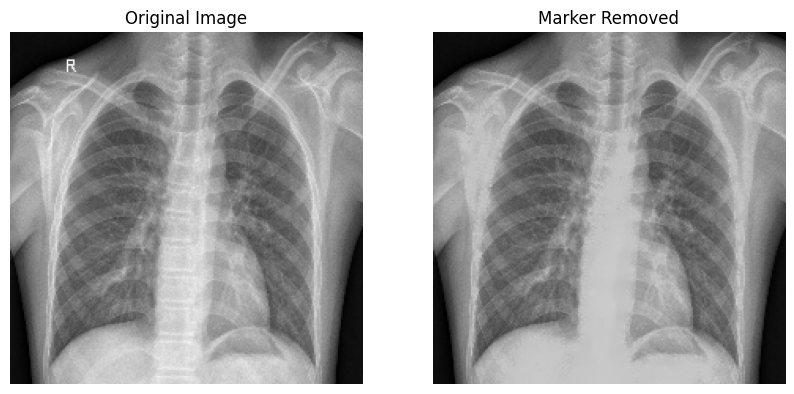

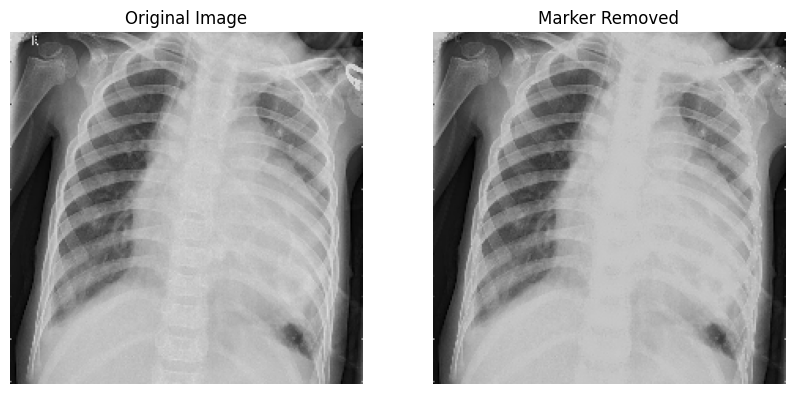

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_text(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY_INV)
    text_mask = cv2.bitwise_not(binary_mask)
    inpainted_image = cv2.inpaint(image, text_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return inpainted_image

def show_marker_removal(original_img):
    marker_removed = remove_text(original_img)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(marker_removed, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Marker Removed")
    axes[1].axis('off')

    plt.show()

    return marker_removed

# Example usage
processed_image = show_marker_removal(normal_sample)
processed_image = show_marker_removal(pneumonia_sample)


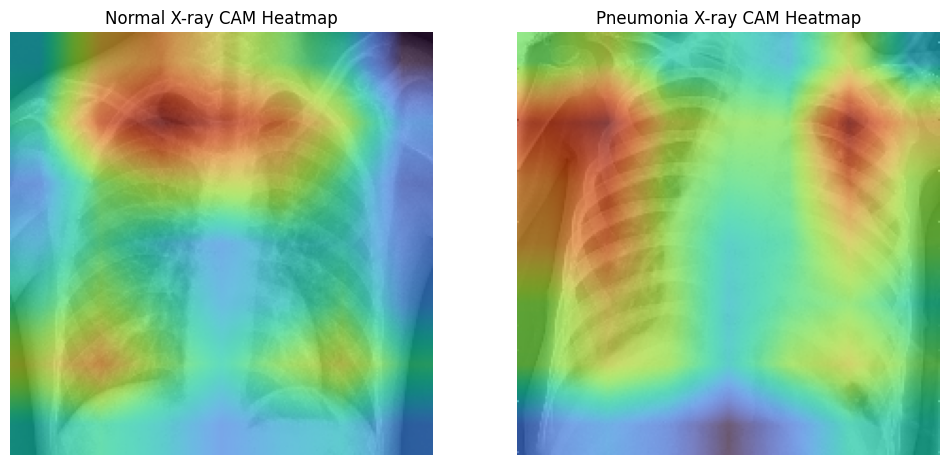

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

def remove_text(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY_INV)
    text_mask = cv2.bitwise_not(binary_mask)
    inpainted_image = cv2.inpaint(image, text_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return inpainted_image

def show_marker_removal(original_img):
    marker_removed = remove_text(original_img)
    return marker_removed

def load_densenet_model():
    model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
    model.classifier = torch.nn.Linear(model.classifier.in_features, 2)
    model.eval()
    return model

def generate_heatmap(feature_maps):
    heatmap = np.mean(feature_maps, axis=0)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(cv2.resize(heatmap, (224, 224)), cv2.COLORMAP_TURBO)
    return heatmap

def generate_cam(image, model, transCrop=224):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    transform = transforms.Compose([
        transforms.Resize((transCrop, transCrop)),
        transforms.ToTensor(),
        normalize
    ])

    image_tensor = transform(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))).unsqueeze_(0).to(device)

    with torch.no_grad():
        features = model.features(image_tensor).cpu().numpy()

    heatmap = generate_heatmap(features[0])
    overlay = cv2.addWeighted(cv2.resize(image, (transCrop, transCrop)), 0.4, heatmap, 0.6, 0)
    return overlay

model = load_densenet_model()

# Process images and remove markers before generating heatmaps
normal_processed = show_marker_removal(normal_sample)
pneumonia_processed = show_marker_removal(pneumonia_sample)

normal_cam = generate_cam(normal_processed, model)
pneumonia_cam = generate_cam(pneumonia_processed, model)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(cv2.cvtColor(normal_cam, cv2.COLOR_BGR2RGB))
axes[0].set_title("Normal X-ray CAM Heatmap")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(pneumonia_cam, cv2.COLOR_BGR2RGB))
axes[1].set_title("Pneumonia X-ray CAM Heatmap")
axes[1].axis('off')

plt.show()


GRAD CAM - Better Visualization


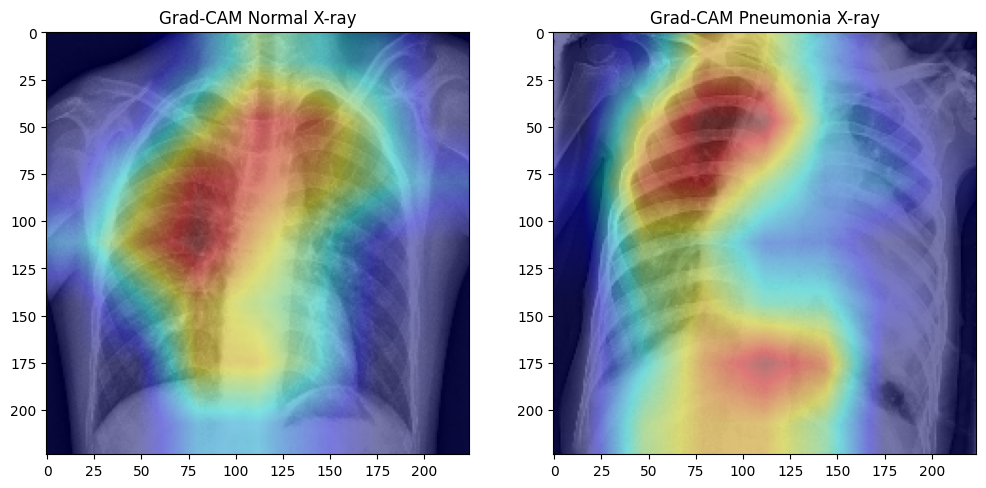

In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image

# Define dataset paths
BASE_PATH = "/content/drive/MyDrive/chest_xray/chest_xray"
TEST_PATH = os.path.join(BASE_PATH, 'test')
NORMAL_PATH = os.path.join(TEST_PATH, 'NORMAL')
PNEUMONIA_PATH = os.path.join(TEST_PATH, 'PNEUMONIA')

# Load DenseNet model
def load_densenet_model():
    model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
    model.classifier = torch.nn.Linear(model.classifier.in_features, 2)  # Adjust for binary classification
    return model

# Function to remove text markers
def remove_text(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY_INV)
    text_mask = cv2.bitwise_not(binary_mask)
    inpainted_image = cv2.inpaint(image, text_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return inpainted_image

# Grad-CAM Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

        # Device configuration
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, image_tensor, class_idx=None):
        image_tensor = image_tensor.to(self.device)
        output = self.model(image_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        self.model.zero_grad()
        one_hot = torch.zeros_like(output).to(self.device)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        # Compute Grad-CAM
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze().cpu().detach().numpy()

        # Normalize
        cam = np.maximum(cam, 0)  # ReLU activation
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)
        cam = cv2.resize(cam, (224, 224))
        return cam

# Load and preprocess images
def preprocess_image(image, dimension):
    transform = transforms.Compose([
        transforms.Resize((dimension, dimension)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transform(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))).unsqueeze(0)

# Overlay heatmap on image
def apply_heatmap(original, heatmap):
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(cv2.resize(original, (224, 224)), 0.6, heatmap_color, 0.4, 0)
    return overlay

# Example Usage
if __name__ == "__main__":
    # Load model
    model = load_densenet_model()
    target_layer = model.features[-1]  # Last conv layer
    grad_cam = GradCAM(model, target_layer)

    # Load available images
    normal_files = [os.path.join(NORMAL_PATH, f) for f in os.listdir(NORMAL_PATH) if f.endswith(('.jpeg', '.png', '.jpg'))]
    pneumonia_files = [os.path.join(PNEUMONIA_PATH, f) for f in os.listdir(PNEUMONIA_PATH) if f.endswith(('.jpeg', '.png', '.jpg'))]

    # Select first available image from each category
    normal_image_path = normal_files[0] if normal_files else None
    pneumonia_image_path = pneumonia_files[0] if pneumonia_files else None

    if not normal_image_path or not pneumonia_image_path:
        raise FileNotFoundError("Error: No images found in one of the categories.")


    # Load and remove markers from images
    normal_image = remove_text(cv2.imread(normal_image_path))
    pneumonia_image = remove_text(cv2.imread(pneumonia_image_path))

    # Preprocess images
    normal_tensor = preprocess_image(normal_image, 224)
    pneumonia_tensor = preprocess_image(pneumonia_image, 224)

    # Generate Grad-CAM heatmaps
    normal_heatmap = grad_cam.generate_heatmap(normal_tensor)
    pneumonia_heatmap = grad_cam.generate_heatmap(pneumonia_tensor)

    # Apply heatmaps to marker-removed images
    normal_overlay = apply_heatmap(normal_image, normal_heatmap)
    pneumonia_overlay = apply_heatmap(pneumonia_image, pneumonia_heatmap)

    # Display results
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(cv2.cvtColor(normal_overlay, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Grad-CAM Normal X-ray")
    axes[1].imshow(cv2.cvtColor(pneumonia_overlay, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Grad-CAM Pneumonia X-ray")
    plt.show()


GAN - identify parts of the image contributes most to the prediction

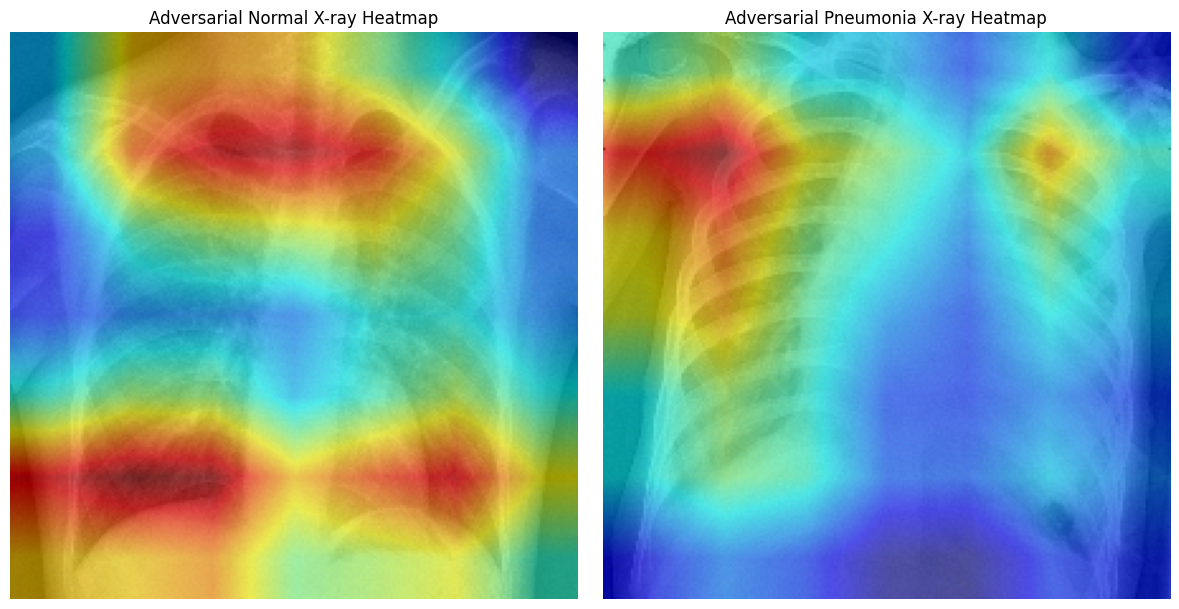

In [18]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image

# Define dataset paths
BASE_PATH = "/content/drive/MyDrive/chest_xray/chest_xray"
TEST_PATH = os.path.join(BASE_PATH, 'test')
NORMAL_PATH = os.path.join(TEST_PATH, 'NORMAL')
PNEUMONIA_PATH = os.path.join(TEST_PATH, 'PNEUMONIA')

# Function to remove text markers
def remove_text(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY_INV)
    text_mask = cv2.bitwise_not(binary_mask)
    inpainted_image = cv2.inpaint(image, text_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return inpainted_image

# FGSM Adversarial Attack
def fgsm_attack(image, model, epsilon=0.02):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = transforms.ToTensor()(Image.fromarray(image)).unsqueeze_(0).to(device)
    image.requires_grad = True

    model.to(device)
    model.eval()

    output = model(image)
    label = output.argmax(dim=1)
    loss = torch.nn.functional.cross_entropy(output, label)
    model.zero_grad()
    loss.backward()

    adversarial_image = image + epsilon * image.grad.sign()
    adversarial_image = adversarial_image.squeeze(0).detach().cpu().numpy()
    adversarial_image = np.transpose(adversarial_image, (1, 2, 0))
    adversarial_image = np.clip(adversarial_image * 255, 0, 255).astype(np.uint8)

    return adversarial_image

# Load and preprocess images
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Error: Image not found at {image_path}")
    image = remove_text(image)
    return image

# Load DenseNet model
def load_densenet_model():
    model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
    model.classifier = nn.Linear(model.classifier.in_features, 2)
    model.eval()
    return model

# Generate heatmap
def generate_heatmap(feature_maps):
    heatmap = np.mean(feature_maps, axis=0)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(cv2.resize(heatmap, (224, 224)), cv2.COLORMAP_JET)
    return heatmap

# Generate CAM
def generate_cam(image, model, transCrop=224):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    transform = transforms.Compose([
        transforms.Resize((transCrop, transCrop)),
        transforms.ToTensor(),
        normalize
    ])

    image_tensor = transform(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))).unsqueeze_(0).to(device)

    with torch.no_grad():
        features = model.features(image_tensor).cpu().numpy()

    heatmap = generate_heatmap(features[0])
    overlay = cv2.addWeighted(cv2.resize(image, (transCrop, transCrop)), 0.4, heatmap, 0.6, 0)
    return overlay

# Example Usage
if __name__ == "__main__":
    model = load_densenet_model()

    # Load available images
    normal_files = [os.path.join(NORMAL_PATH, f) for f in os.listdir(NORMAL_PATH) if f.endswith(('.jpeg', '.png', '.jpg'))]
    pneumonia_files = [os.path.join(PNEUMONIA_PATH, f) for f in os.listdir(PNEUMONIA_PATH) if f.endswith(('.jpeg', '.png', '.jpg'))]

    normal_image_path = normal_files[0] if normal_files else None
    pneumonia_image_path = pneumonia_files[0] if pneumonia_files else None

    if not normal_image_path or not pneumonia_image_path:
        raise FileNotFoundError("Error: No images found in one of the categories.")

    # Load and process images
    normal_image = load_and_preprocess_image(normal_image_path)
    pneumonia_image = load_and_preprocess_image(pneumonia_image_path)

    normal_adv_image = fgsm_attack(normal_image, model)
    pneumonia_adv_image = fgsm_attack(pneumonia_image, model)

    # Generate CAM heatmaps
    normal_adv_cam = generate_cam(normal_adv_image, model)
    pneumonia_adv_cam = generate_cam(pneumonia_adv_image, model)

    # Display results side by side
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(normal_adv_cam, cv2.COLOR_BGR2RGB))
    plt.title("Adversarial Normal X-ray Heatmap")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(pneumonia_adv_cam, cv2.COLOR_BGR2RGB))
    plt.title("Adversarial Pneumonia X-ray Heatmap")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
#--DEBUG--
'''
import os
import cv2

# Define dataset paths
BASE_PATH = "/content/drive/MyDrive/chest_xray/chest_xray"
TEST_PATH = os.path.join(BASE_PATH, 'test')
NORMAL_PATH = os.path.join(TEST_PATH, 'NORMAL')
PNEUMONIA_PATH = os.path.join(TEST_PATH, 'PNEUMONIA')

# Check if directories exist
if not os.path.exists(NORMAL_PATH):
    raise FileNotFoundError(f"Error: The folder '{NORMAL_PATH}' does not exist.")
if not os.path.exists(PNEUMONIA_PATH):
    raise FileNotFoundError(f"Error: The folder '{PNEUMONIA_PATH}' does not exist.")

# Function to load images from a folder
def load_images(folder_path):
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpeg', '.png', '.jpg'))]
    images = [cv2.imread(img_path) for img_path in image_files if cv2.imread(img_path) is not None]
    return images

# Load images
normal_images = load_images(NORMAL_PATH)
pneumonia_images = load_images(PNEUMONIA_PATH)

if not normal_images or not pneumonia_images:
    raise FileNotFoundError("Error: No images found in one of the categories.")

# Select first sample from each category
normal_sample = normal_images[0]
pneumonia_sample = pneumonia_images[0]
'''

REFERENCES:

* https://www.mdpi.com/2078-2489/16/1/53
* https://pmc.ncbi.nlm.nih.gov/articles/PMC8423280/





